# <font color ='blue'>Zillow Clustering Project
    
<img src="zillow_logo.png" alt="Zillow Logo" title="Zillow Logo" width="300" height="100" align="right"/>
    
    
# <p style="font-size:50px" align="center">Zestimate Error</p> <sub>By Kaniela Denis and Mason Sherbondy - 10 Jan 2022</sub>

In [1]:
# import pandas and numpy to start coding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import acquire
import prepare
import explore
import clustering
import modeling
import viz

import warnings
warnings.filterwarnings("ignore")

## Project Goal
The goal of this project is to discover drivers for Zillow Zestimate Error by using clustering. It is the hope of the project that clustering features will decrease the RMSE for regression modeling the logerror.

## Project Description
By understanding the drivers for the Zestimate error, Zillow models can be adjusted to increase accuracy of house values. This project will explore clusters of data to determine features that drive Zestimate error in order to improve the accuracy of current regression models.

## Data Dictionary

In [2]:
# Read Data Dictionary from working directory
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedfinishedsquarefeet',Calculated total finished living area of the ...
8,'fips',Federal Information Processing Standard code ...
9,'fullbathcnt',"Number of full bathrooms (sink, shower + bath..."


<hr style="border:2px solid blue"> </hr>

# Wrangle

## Actions Taken:
1. Data aquired from MySQL database and included only 2017 single family home transactions
2. 52K records pulled, included 1.7M nulls
3. Removed rows that have no bedrooms or no bathroms or have too smal an area
4. Removed columns with more than 50% null values and rows with more than 30% null values
5. Dropped all left over nulls as amounts were relatively small
6. Removed outliers that were 1.5 times Interquartile Range above third quartile or below first quartile
7. Dropped columns that couldn't be used or were redundant
8. Renamed columsn for readability
9. Created new columns for dimension reduction
10. Split the data into train, test, validate using 56%, 24%, 20% ratio for each set
11. Created scaled columns for exploration, clustering, and modeling
12. After Wrangle: 31K records

In [3]:
# pulls zillow data from MySQL server, for single family homes with transaction in 2017, and writes a csv
df = acquire.get_zillow()

In [4]:
# Wrangles data by removing nulls, outliers, useless columns, then renames, splits, and scales
df, train, validate, test, train_scaled, validate_scaled, test_scaled = prepare.wrangle(df)

<hr style="border:2px solid blue"> </hr>

# Exploratory Data Analysis

## Initital Questions
* Do any of the features correlate with the target variable?
* Is log error concentrated in any one area?
* Is log error higher in any county?

### Explore Q I
#### Do any features correlate with the target variable?

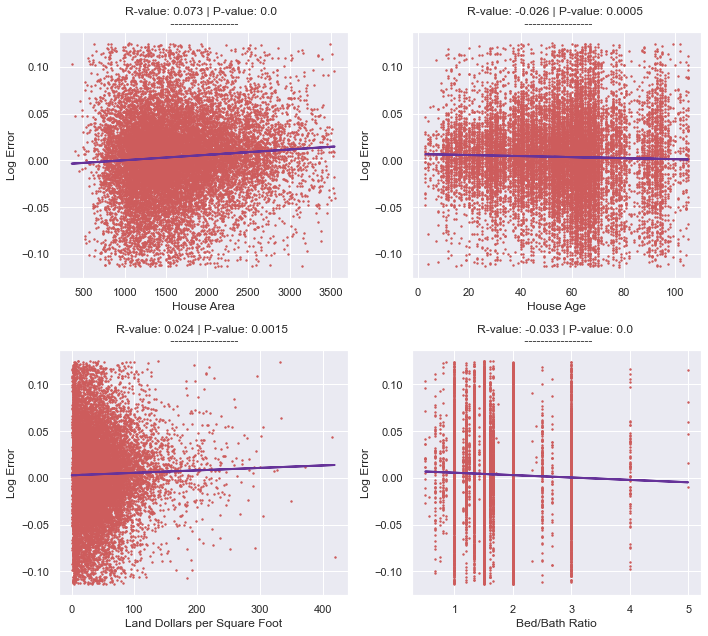

In [5]:
explore.display_correlations_z(train)

### Chart takeaways
* Small correlation between log error and house area (.073)
* Small negative correlation between age and log error (-0.026)
* Small correlation between land dollars/sqft and log error (.024)
* Small negative correlation between bed/bath ratio and log error (-0.033)

### Explore Q II
#### Is log error concentrated in any one area?

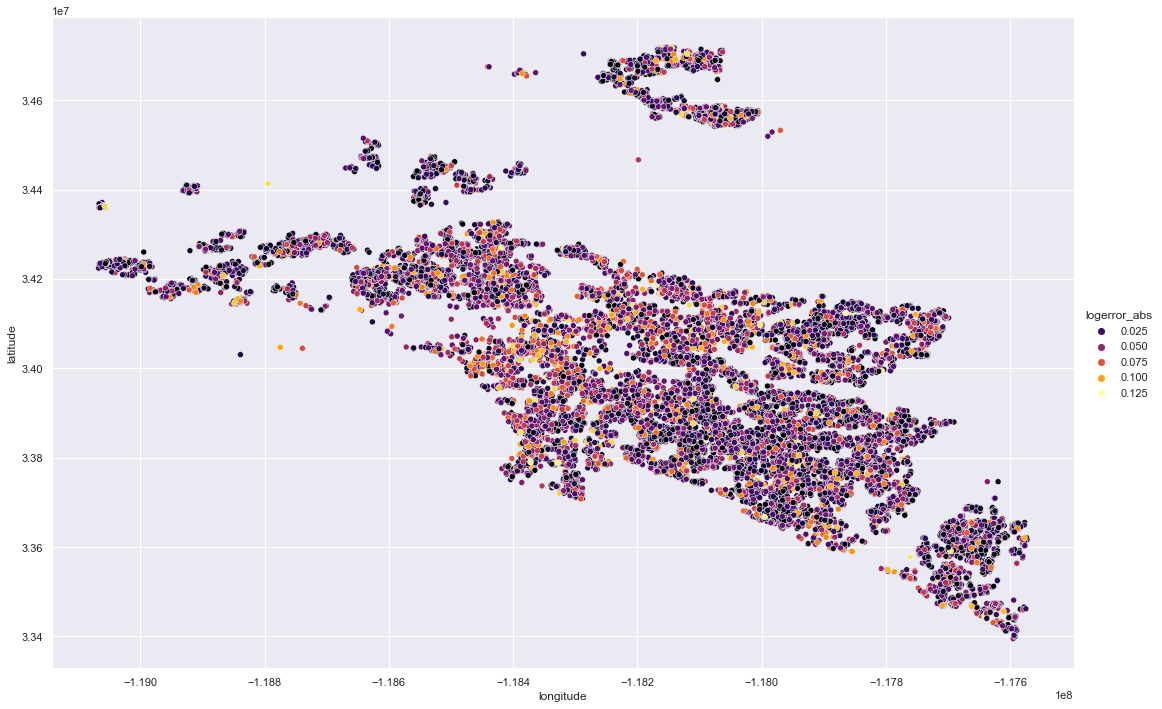

In [6]:
#relational scatter plot of longitude and latitude with a hue of log error
explore.show_long_lat(train)

### Takeaways
* log error seems proprotionaly spread out everywhere

### Explore Q III
#### Is log error higher on average in any county?

In [7]:
#assign variables to respective county data
LA = train[train.county == 'LA']
OC = train[train.county == 'OC']
ventura = train[train.county == 'Ventura']

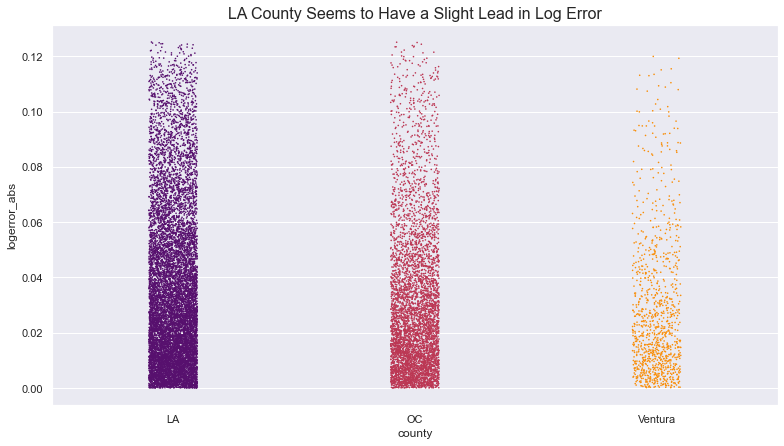

In [8]:
#juxtapose log error through viz
explore.display_strips(train);

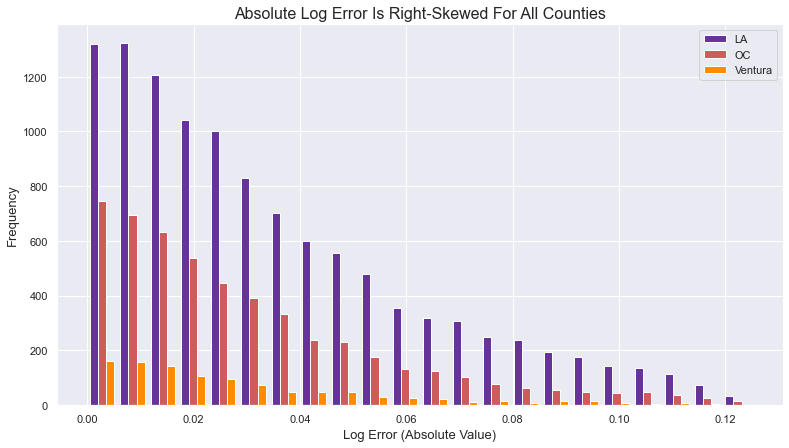

In [9]:
#visualize distribution target variable across different counties
explore.juxtapose_distributions(LA, OC, ventura)

It's not immediately clear to me, but it looks like LA has on average higher log error.

In [10]:
#juxtapose county logerror averages
juxt = pd.Series([LA.logerror_abs.mean(), OC.logerror_abs.mean(), ventura.logerror_abs.mean()])
juxt

0    0.034910
1    0.030034
2    0.027812
dtype: float64

Is this a signficant difference? Let's run some tests.

## Statistical Testing

Assumptions for T-Test:
* X Normality - an abdunance of observations means this assumption is met (central limit theorem) 
* X Independent observations - log error in one county is not dependent on the log error from another county
* Equal variances - will test for equal variances

In [11]:
#juxtapose county logerror variances
juxt_var = pd.Series([LA.logerror_abs.var(), OC.logerror_abs.var(), ventura.logerror_abs.var()])
juxt_var

0    0.000803
1    0.000683
2    0.000622
dtype: float64

Variances at a glance seem the same, but I'm unsure. Let's run a levene's test.

In [12]:
#run levene's to test for homoscedasticity
stat, p = stats.levene(LA.logerror_abs, OC.logerror_abs)
stat, p

(63.97948915777188, 1.339623071554423e-15)

Low p-value suggests these variances are not the same. OC and Ventura variances also seem the same, but let's test just to be sure, since the variances for LA and OC didn't seem all that different either.

In [13]:
#run levene's 
stat, p = stats.levene(OC.logerror_abs, ventura.logerror_abs)
stat, p

(3.546248588380879, 0.059726863609449496)

High p-value suggests that the variances are the same. Let's form some hypotheses and run some t-tests.

#### Null hypothesis: LA county's log error is the same or less as Orange County's log error.
#### Alternate hypothesis: LA county's log error is greater than Orange County's log error.

In [14]:
#run a t-test between the log error populations for LA and OC
t_stat, p = stats.ttest_ind(LA.logerror_abs, OC.logerror_abs, equal_var = False, alternative = 'greater')
t_stat, p

(10.843945701718907, 1.4713490469609616e-27)

#### With a positive t-statistic and a low p-value, I can confidently reject the null hypothesis that LA county's log error is the same or less as OC's. LA's log error is signficantly greater.

What about OC and Ventura?

#### Null hypothesis: OC's log error is the same or less as Ventura's log error.
#### Alternate hypothesis: OC's log error is greater than Ventura's log error.

In [15]:
#run test between log error populations of OC and Ventura County.
t_stat, p = stats.ttest_ind(OC.logerror_abs, ventura.logerror_abs, alternative = 'greater')
t_stat, p

(2.5177529359815893, 0.0059177647198305604)

#### I can confidently reject the null hypothesis that OC's log error is the same or less as Ventura County's. OC has significantly greater log error.

### Takeaways
* LA county's log error is significantly greater than OC's log error.
* OC's log error is significantly greater than Ventura County's log error.

## Exploration Summary
* Small correlation between log error and house area (.073)
* Small negative correlation between age and log error (-0.026)
* Small correlation between land dollars/sqft and log error (.024)
* Small negative correlation between bed/bath ratio and log error (-0.033)
* High log error does not seem to geographically cluster.
* LA county's average log error > OC's average log error > Ventura County's average log error.

## Move Forward: Age, House Area, Dollar per Sqft of Land, and Bed to Bath Ratio

<hr style="border:2px solid blue"> </hr>

# Clustering


## Cluster Combo 1: Age and House Area

In [16]:
# Create cluster on features Age and House Area
train, validate, test = clustering.cluster_combo_1(train, validate, test, train_scaled, validate_scaled, test_scaled)

In [17]:
# check mean of logerror for each cluster
train.groupby(by='cluster').logerror_abs.mean()

cluster
0    0.034820
1    0.028358
2    0.033275
3    0.034289
4    0.026652
5    0.040678
Name: logerror_abs, dtype: float64

## Takeaway:
- High: 0.0407
- Low: 0.0267
- Diff: 0.014

## Cluster Combo 2: Age and Dollar Per Sqft of Land

In [18]:
# Creates cluster based on features age and land_dollar_sqft
train, validate, test = clustering.cluster_combo_2(train, validate, test, train_scaled, validate_scaled, test_scaled)

In [19]:
# check mean of logerror for each cluster
train.groupby(by='cluster').logerror_abs.mean()

cluster
0    0.031397
1    0.040463
2    0.035747
3    0.027624
4    0.026967
5    0.032690
Name: logerror_abs, dtype: float64

## Takeaway:
- High: 0.0405
- Low: 0.0270
- Diff: 0.0135

## Cluster Combo 3: Age and Bed-to-Bath Ratio

In [20]:
# creates cluster based on age and bed_bath_ratio
train, validate, test = clustering.cluster_combo_3(train, validate, test, train_scaled, validate_scaled, test_scaled)

In [21]:
# check mean of logerror for each cluster
train.groupby(by='cluster').logerror_abs.mean()

cluster
0    0.030731
1    0.027163
2    0.040674
3    0.035557
4    0.034350
5    0.034266
Name: logerror_abs, dtype: float64

## Takeaway:
- High: 0.0407
- Low: 0.0272
- Diff: 0.0135

<hr style="border:2px solid blue"> </hr>

## Clustering Result:
- Cluser 1 based on Age and House Area has the largest difference between highest logerror and lowest logerror clusters
- Move forward with Modeling with Cluster 1

In [22]:
# creates cluster based on age and house_area
train, validate, test = clustering.cluster_combo_1(train, validate, test, train_scaled, validate_scaled, test_scaled)

# Modeling

## Modeling Prep:
- Created dummy columns for cluster 1
- Created X and y versions of train, validate, test
- Created scaled X and y versions for feature engineering and selection

In [23]:
# creates dummies, X_y versions, and X_y_scaled
train, validate, test, X_train, X_validate, X_test, y_train, y_validate, y_test, X_train_scaled, X_validate_scaled, X_test_scaled = modeling.model_prep(train, validate, test)

## Feature Engineering
- Used Select K Best and Recursive Feature Engineering

In [24]:
# uses select k best to find best 3 features
f_feature = modeling.select_k_best(X_train_scaled, y_train)
f_feature

['age', 'cluster_1', 'cluster_5']

In [25]:
# uses recursive feature engineering to find best 3 features
rfe_feature = modeling.rfe(X_train_scaled, y_train)
rfe_feature

['land_dollar_sqft', 'house_dollar_sqft', 'age']

## Move Foward into Modeling with Features:
1. Age
2. Cluster 1 and Cluster 5
3. Dollar Per Sqft of House
4. Dollar Per Sqft of Land


## Baseline Model

In [26]:
# creates baseline model based on logerror mean
y_train, y_validate, metric_df= modeling.model_baseline(y_train, y_validate)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_test:,RMSE_diff:
0,mean_baseline,0.027634,0.027508,none,0.000126


## Takeaway:
- Basesline Model set with mean logerror has RMSE of 0.0276
- Validate shows not over/under fit

## Model 1: OLS without Cluster
- Features: Age, Bed-to-Bath Ratio, Dollar Per Sqft of House, Dollar Per Sqft of Land, and Logerror Absolute Value

In [27]:
# Uses ols regression on features without cluster and five features
y_train, y_validate, metric_df = modeling.model_ols_wo_cluster(train, validate, test, y_train, y_validate, metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_test:,RMSE_diff:
0,mean_baseline,0.027634,0.027508,none,0.000126
1,ols_regressor_wo_cluster,0.027308,0.027182,none,0.000126


## Takeaway:
- Only .0003 better than baseline
- Validate shows not under/over fit

## Model 2: OLS with Cluster 1 Combo (Age & House Area)
- Features: Same as Model 1 plus Cluster 1 and Cluster 5

In [28]:
# uses ols regression with cluster and five features
y_train, y_validate, metric_df = modeling.model_osl_w_cluster(train, validate, test, y_train, y_validate, metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_test:,RMSE_diff:
0,mean_baseline,0.027634,0.027508,none,0.000126
1,ols_regressor_wo_cluster,0.027308,0.027182,none,0.000126
2,ols_regressor_w_cluster,0.027304,0.027177,none,0.000127


## Takeaway:
- Only .000004 better than Model 1
- Validate show not under/over fit

## Model 3: OLS with Cluster 2 and More Features (Longitude, Latitude, and Tax Rate)
- Features: Same as Model 2 plus longitude, latitude, and tax rate

In [29]:
# uses OlS with Cluster and addional features: longitude, latitude, tax rat
y_train, y_validate, metric_df = modeling.model_osl_w_cluster_more_features(train, validate, test, y_train, y_validate, metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_test:,RMSE_diff:
0,mean_baseline,0.027634,0.027508,none,0.000126
1,ols_regressor_wo_cluster,0.027308,0.027182,none,0.000126
2,ols_regressor_w_cluster,0.027304,0.027177,none,0.000127
3,ols_regressor_w_cluster_and_features,0.027300,0.027176,none,0.000125


## Takeaway:
- Only .000004 better than Model 2
- Validate show not under/over fit

## Model 4: Polynomial Regression with Cluster 2 and More Features
- Features: Same as Model 3

In [30]:
# uses polynomial regression model with 10 featursdd
y_train, y_validate, X_test_degree2, ols2, rmse_train, metric_df = modeling.model_ployreg_w_cluster_more_features(train, validate, test, y_train, y_validate, X_train_scaled, X_validate_scaled, X_test_scaled, metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_test:,RMSE_diff:
0,mean_baseline,0.027634,0.027508,none,0.000126
1,ols_regressor_wo_cluster,0.027308,0.027182,none,0.000126
2,ols_regressor_w_cluster,0.027304,0.027177,none,0.000127
3,ols_regressor_w_cluster_and_features,0.027300,0.027176,none,0.000125
4,polyn_reg_cluster_and_features,0.027136,0.027158,none,-0.000022


## Takeaway:
- Only .0002 better than Model 3
- Validate show not under/over fit

## Modeling Results:
- Polynomial Regressor has the lowest RMSE
- Go foward with Model 4

# Visualize Predictions:

### Plot Actual vs. Predicted Log Error

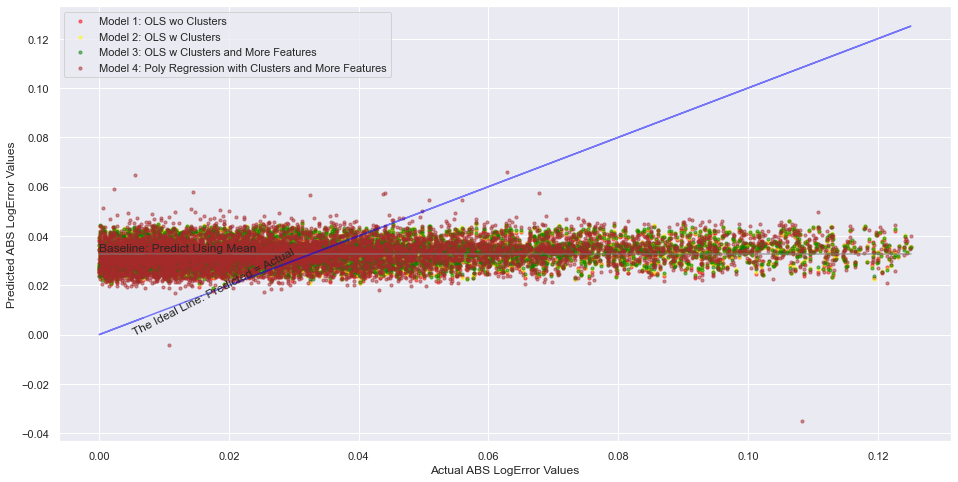

In [31]:
viz.plot_predictions(y_validate)

## Takeaway:
- Models are only slightly better than baseline

## Plot Distribution of Actual vs. Predicted Log Error

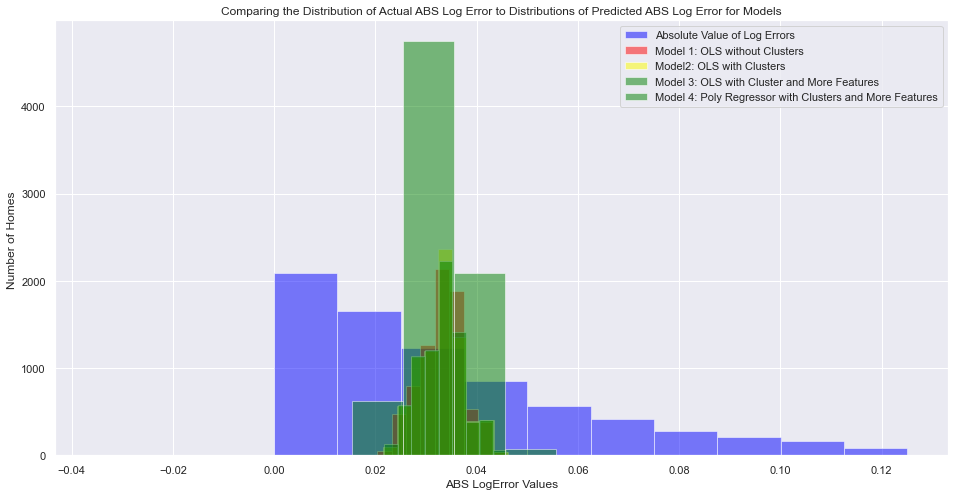

In [32]:
viz.plot_pred_actual_hist(y_validate)

## Takeaway: 
- Large area of actuals are being missed by the predictions

## Plot Residuals of Predicted Log Error

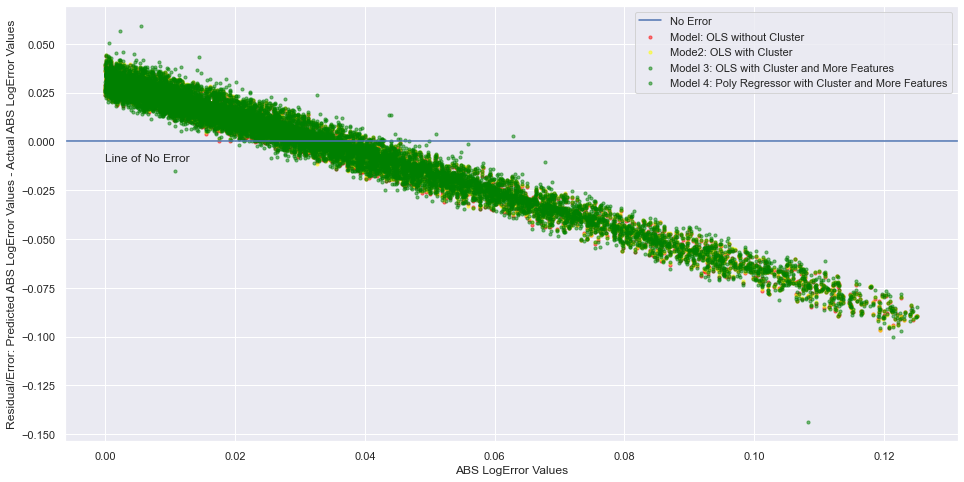

In [33]:
viz.plot_residuals(y_validate)

## Takeaways:
- Model Needs Improvement. Residuals Form a Trend

# Final Test Using Polynomial Model

In [34]:
# uses model 4 (polynomial regression) on test set
y_test, metric_df = modeling.test_polyreg(X_test_degree2, y_test, ols2, rmse_train, metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_test:,RMSE_diff:
0,mean_baseline,0.027634,0.027508,none,0.000126
1,ols_regressor_wo_cluster,0.027308,0.027182,none,0.000126
2,ols_regressor_w_cluster,0.027304,0.027177,none,0.000127
3,ols_regressor_w_cluster_and_features,0.0273,0.027176,none,0.000125
4,polyn_reg_cluster_and_features,0.027136,0.027158,none,-0.000022
5,test_poly_reg_w_cluster_and_feature,none,none,0.02732,-0.000184


## Results:
- Test confirms that the Model is consistent with new data

# Conclusion

### Summary
- Drivers of Zestimate Error: Age, House Area, Bed Bath Ratio, Dollar per Land Sqft, 
- Creating clusters improved modeling from baseline slightly
- Models need improvement

## Recommendations
- Don't immplement this model since he needs improvement

## Next Steps
- Increase dimension reduction
- With more time, investigate into why LA county has higher average errors

### Thank You!!!